# Demo - Siren

In [63]:
import os
import sys

from pyprojroot import here

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# spyder up to find the root
root = here(project_files=[".root"])
exp = here(
    relative_project_path=root.joinpath("experiments/expv2"), project_files=[".local"]
)


# append to path
sys.path.append(str(root))
sys.path.append(str(exp))

In [64]:
import imageio
import numpy as np
import pytorch_lightning as pl
import torch
import wandb
from inr4ssh._src.data.ssh_obs import (
    load_ssh_altimetry_data_test,
    load_ssh_altimetry_data_train,
    load_ssh_correction,
)
from inr4ssh._src.datamodules.ssh_obs import SSHAltimetry
from inr4ssh._src.features.data_struct import df_2_xr
from inr4ssh._src.interp import interp_on_alongtrack
from inr4ssh._src.metrics.psd import compute_psd_scores, select_track_segments
from inr4ssh._src.metrics.stats import (
    calculate_nrmse,
    calculate_nrmse_elementwise,
    calculate_rmse_elementwise,
)
from inr4ssh._src.models.activations import get_activation
from inr4ssh._src.models.siren import ModulatedSirenNet, Modulator, Siren, SirenNet
from inr4ssh._src.postprocess.ssh_obs import postprocess
from inr4ssh._src.preprocess.coords import (
    correct_coordinate_labels,
    correct_longitude_domain,
)
from inr4ssh._src.preprocess.subset import spatial_subset, temporal_subset
from inr4ssh._src.viz.psd import plot_psd_score, plot_psd_spectrum
from loguru import logger
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, WandbLogger
from skorch.dataset import ValidSplit
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.notebook import tqdm as tqdm

pl.seed_everything(123)

import matplotlib.pyplot as plt
import seaborn as sns
from inr4ssh._src.viz.movie import create_movie

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Global seed set to 123


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import argparse

import config

In [113]:
# initialize argparse
parser = argparse.ArgumentParser()

# add all experiment arguments
parser = config.add_logging_args(parser)
parser = config.add_data_dir_args(parser)
parser = config.add_data_preprocess_args(parser)
parser = config.add_feature_transform_args(parser)
parser = config.add_train_split_args(parser)
parser = config.add_dataloader_args(parser)
parser = config.add_model_args(parser)
parser = config.add_loss_args(parser)
parser = config.add_optimizer_args(parser)
parser = config.add_eval_data_args(parser)
parser = config.add_eval_metrics_args(parser)
parser = config.add_viz_data_args(parser)

# parse args
args = parser.parse_args([])

# modify args (PERSONAL)
args.train_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train"
args.ref_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref"
args.test_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test"

# # modify args (MEOMCAL1)
# args.train_data_dir = "/home/johnsonj/data/dc_2021/raw/train"
# args.ref_data_dir = "/home/johnsonj/data/dc_2021/raw/ref"
# args.test_data_dir = "/home/johnsonj/data/dc_2021/raw/test"
#
# args.time_min = "2017-01-01"
# args.time_max = "2017-02-01"
# args.eval_time_min = "2017-01-01"
# args.eval_time_max = "2017-02-01"
# args.eval_dtime = "12_h"

# logger args
# ige/inr4ssh/2avm7u7m
# ige/inr4ssh/3rzy4mbv - genial-deluge-8
# ige/inr4ssh/nlbgt9aq - dazzling tree 12
args.wandb_resume = True
args.wandb_mode = "online"
args.wandb_project = "inr4ssh"
args.wandb_entity = "ige"
args.wandb_log_dir = "/Users/eman/code_projects/logs"
args.wandb_id = "nlbgt9aq"

In [114]:
wandb_run = wandb.init(
    # config=args,
    mode=args.wandb_mode,
    project=args.wandb_project,
    entity=args.wandb_entity,
    dir=args.wandb_log_dir,
    resume=args.wandb_resume,
    id=args.wandb_id
)

wandb: WARNING Tried to auto resume run with id 3rzy4mbv but id nlbgt9aq is set.


nrmse_mean_alongtrack_custom,▁
nrmse_mean_alongtrack_iqr,▁
nrmse_mean_alongtrack_mean,▁
nrmse_mean_alongtrack_minmax,▁
nrmse_mean_alongtrack_std,▁
nrmse_mean_grid,▁
nrmse_std_alongtrack_custom,▁
nrmse_std_alongtrack_iqr,▁
nrmse_std_alongtrack_mean,▁
nrmse_std_alongtrack_minmax,▁
nrmse_std_alongtrack_std,▁


In [115]:
args = wandb_run.config
args

{'dlat': 0.2, 'dlon': 0.2, 'loss': 'mse', 'dtime': '1_D', 'model': 'siren', 'device': 'cuda', 'encoder': None, 'lat_max': 53, 'lat_min': 23, 'lon_max': 315, 'lon_min': 285, 'loss_qg': False, 'siren_c': 6, 'n_hidden': 6, 'siren_w0': 1, 'time_max': '2018-01-31', 'time_min': '2016-12-01', 'viz_dlat': 0.1, 'viz_dlon': 0.1, 'wandb_id': None, 'eval_dlat': 0.2, 'eval_dlon': 0.2, 'optimizer': 'adam', 'viz_dtime': '1_D', 'activation': 'swish', 'batch_size': 4096, 'eval_dtime': '1_D', 'hidden_dim': 512, 'lat_buffer': 1, 'lon_buffer': 1, 'model_seed': 42, 'num_epochs': 3000, 'smoke_test': False, 'train_size': 0.9, 'wandb_mode': 'offline', 'julian_time': True, 'loss_qg_reg': 0.1, 'time_buffer': 7, 'viz_lat_max': 43, 'viz_lat_min': 33, 'viz_lon_max': 305, 'viz_lon_min': 295, 'abs_time_max': '2019-01-01', 'abs_time_min': '2016-01-01', 'eval_lat_max': 43, 'eval_lat_min': 33, 'eval_lon_max': 305, 'eval_lon_min': 295, 'eval_min_obs': 10, 'lr_scheduler': 'reduce', 'ref_data_dir': '/gpfswork/rech/cli/uvo

In [116]:

# modify args (PERSONAL)
args.train_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/train"
args.ref_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/ref"
args.test_data_dir = "/Users/eman/.CMVolumes/cal1_workdir/data/dc_2021/raw/test"


to extract a default argument if it is in the name space
`lr = getattr(args, "lr", 1e-4)`

In [117]:
logger.info("Initializing data module...")
dm = SSHAltimetry(args)

2022-07-06 11:53:15.626 | INFO     | __main__:<cell line: 1>:1 - Initializing data module...


In [118]:
dm.setup()

2022-07-06 11:53:16.120 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:24 - Getting training data...
2022-07-06 11:53:16.120 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:58 - loading data...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.26it/s]
2022-07-06 11:53:16.779 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:61 - subsetting data...
2022-07-06 11:53:17.002 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:64 - getting feature scaler...
2022-07-06 11:53:17.002 | INFO     | inr4ssh._src.datamodules.ssh_obs:get_train_data:67 - feature scaling...
2022-07-06 11:53:17.412 | INFO     | inr4ssh._src.datamodules.ssh_obs:setup:28 - Train/Va

In [119]:
dl_train = dm.train_dataloader()
dl_valid = dm.val_dataloader()
dl_predict = dm.predict_dataloader()

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [120]:
len(dm.ds_train), len(dm.ds_valid), len(dm.ds_predict)

(1611084, 179010, 967980)

## Skorch Training

In [121]:
X_train, y_train = dm.ds_train[:]
X_valid, y_valid = dm.ds_valid[:]
(X_test,) = dm.ds_predict[:]
X_train = torch.cat([X_train, X_valid])
y_train = torch.cat([y_train, y_valid])

In [122]:
X_train.shape, X_test.shape

(torch.Size([1790094, 4]), torch.Size([967980, 4]))

In [123]:
logger.info("Creating neural network...")
dim_in = X_train.shape[1]
dim_hidden = args.hidden_dim
dim_out = y_train.shape[1]
num_layers = args.n_hidden
w0 = args.siren_w0
w0_initial = args.siren_w0_initial
c = args.siren_c
final_activation = get_activation(args.final_activation)

2022-07-06 11:53:22.220 | INFO     | __main__:<cell line: 1>:1 - Creating neural network...


In [124]:
siren_net = SirenNet(
    dim_in=dim_in,
    dim_hidden=dim_hidden,
    dim_out=dim_out,
    num_layers=num_layers,
    w0=w0,
    w0_initial=w0_initial,
    final_activation=final_activation,
)

In [125]:
# if torch.has_mps:
#     device = "mps"
# elif torch.has_cuda:
#     device = "cuda"
# else:
#     device = "cpu"
device = "cpu"

In [126]:
# args.num_epochs = 500
# args.learning_rate = 1e-3

In [127]:
# learning rate scheduler
lr_scheduler = LRScheduler(
    policy="ReduceLROnPlateau",
    monitor="valid_loss",
    mode="min",
    factor=0.1,
    patience=10,
)
# learning rate scheduler

# lr_scheduler = LRScheduler(
#     policy=CosineAnnealingLR,
#     T_max=args.num_epochs
# )

# early stopping
estop_callback = EarlyStopping(
    monitor="valid_loss",
    patience=50,
)

wandb_callback = WandbLogger(wandb_run, save_model=True)

callbacks = [
    ("earlystopping", estop_callback),
    ("lrscheduler", lr_scheduler),
    ("wandb_logger", wandb_callback),
]

In [128]:
# train split percentage
train_split = ValidSplit(0.1, stratified=False)

In [129]:
skorch_net = NeuralNetRegressor(
    module=siren_net,
    max_epochs=args.num_epochs,
    lr=args.learning_rate,
    batch_size=args.batch_size,
    device=device,
    optimizer=torch.optim.Adam,
    train_split=train_split,
    callbacks=callbacks,
)

In [130]:
# if args.server == "jz":
# get id (from this run or a run you can set)
run_id = wandb_run.id

# initialize api
api = wandb.Api()

# get run
run = api.run(f"{args.wandb_entity}/{args.wandb_project}/{run_id}")

# download the files
files = [
    "scaler.pickle", 
    f"best_model.pth"
    # "checkpoints/last.ckpt"
]

for ifile in files:
    
    run.file(ifile).download(replace=True)

In [131]:
from inr4ssh._src.io import load_object

In [132]:
scaler = load_object("./scaler.pickle")

In [133]:
skorch_net.initialize()  # This is important!
skorch_net.load_params(f_params='./best_model.pth')

In [134]:
# skorch_net.fit(X_train, y_train)

In [135]:
# fig, ax = plt.subplots()

# ax.plot(skorch_net.history[:, "train_loss"], label="Train Loss")
# ax.plot(skorch_net.history[:, "valid_loss"], label="Validation Loss")

# ax.set(yscale="log", xlabel="Epochs", ylabel="Mean Squared Error")

# plt.legend()
# plt.show()

## Predictions

### SSH Along Track

In [136]:
%%time

# open along track dataset
ds_alongtrack = load_ssh_altimetry_data_test(args.test_data_dir)

# correct labels
ds_alongtrack = correct_coordinate_labels(ds_alongtrack)

# correct longitude domain
ds_alongtrack = correct_longitude_domain(ds_alongtrack)

# temporal subset
ds_alongtrack = temporal_subset(
    ds_alongtrack,
    time_min=np.datetime64(args.time_min),
    time_max=np.datetime64(args.time_max),
    time_buffer=args.time_buffer,
)

# spatial subset
ds_alongtrack = spatial_subset(
    ds_alongtrack,
    lon_min=args.eval_lon_min,
    lon_max=args.eval_lon_max,
    lon_buffer=args.eval_lon_buffer,
    lat_min=args.eval_lat_min,
    lat_max=args.eval_lat_max,
    lat_buffer=args.eval_lat_buffer,
)

# convert to dataframe
ds_alongtrack = ds_alongtrack.to_dataframe().reset_index().dropna()

# convert to df using the transform
X_test = dm.scaler.transform(ds_alongtrack)
y_test = ds_alongtrack["sla_unfiltered"]

CPU times: user 10.8 s, sys: 884 ms, total: 11.7 s
Wall time: 11.8 s


In [137]:
%%time
import time

t0 = time.time()
predictions = skorch_net.predict(torch.Tensor(X_test))
t1 = time.time() - t0

wandb_run.log(
    {
        "time_predict_alongtrack": t1,
    }
)

CPU times: user 3.66 s, sys: 222 ms, total: 3.88 s
Wall time: 1.94 s


#### Stats

In [138]:
rmse_mean, rmse_std = calculate_rmse_elementwise(y_test, predictions)

wandb_run.log(
    {
        f"rmse_mean_alongtrack": rmse_mean,
        f"rmse_std_alongtrack": rmse_std,
    }
)

In [139]:
print(f"RMSE: {rmse_mean}\nRMSE (stddev): {rmse_std}")

RMSE: 0.054091013967990875
RMSE (stddev): 0.05719185620546341


In [140]:
metrics = ["custom", "std", "mean", "minmax", "iqr"]

for imetric in metrics:

    nrmse_mean, nrmse_std = calculate_nrmse_elementwise(y_test, predictions, imetric)

    print(f"RMSE ({imetric}): mean - {nrmse_mean:.4f}, stddev - {nrmse_std:.4f}")

    wandb_run.log(
        {
            f"nrmse_mean_alongtrack_{imetric}": nrmse_mean,
            f"nrmse_std_alongtrack_{imetric}": nrmse_std,
        }
    )

RMSE (custom): mean - 0.7801, stddev - 0.2325
RMSE (std): mean - 0.7565, stddev - 0.2575
RMSE (mean): mean - 0.4885, stddev - 0.5409
RMSE (minmax): mean - 0.9765, stddev - 0.0249
RMSE (iqr): mean - 0.7348, stddev - 0.2804


#### PSD Score

In [141]:
psd_metrics = compute_psd_scores(
    ssh_true=y_test.squeeze(),
    ssh_pred=predictions.squeeze(),
    delta_x=args.eval_psd_velocity * args.eval_psd_delta_t,
    npt=None,
    scaling="density",
    noverlap=0,
)

In [142]:
print(psd_metrics)

Resolved Scale: 176.742 (km)


In [143]:
wandb_run.log(
    {
        "resolved_scale_alongtrack": psd_metrics.resolved_scale,
    }
)

#### Viz - PSD Score

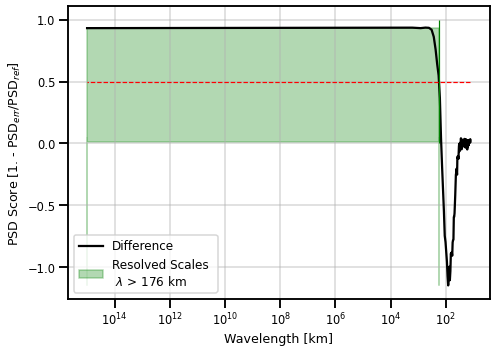

In [144]:
fig, ax = plot_psd_score(
    psd_diff=psd_metrics.psd_diff,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
    resolved_scale=psd_metrics.resolved_scale,
)

wandb_run.log(
    {
        "psd_score_alongtrack": wandb.Image(fig),
    }
)

#### Viz - PSD Spectrum

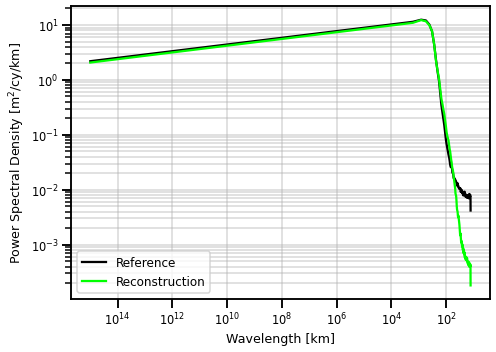

In [145]:
fig, ax = plot_psd_spectrum(
    psd_study=psd_metrics.psd_study,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
)

wandb_run.log(
    {
        "psd_spectrum_alongtrack": wandb.Image(fig),
    }
)

### SSH Grid

In [146]:
%%time
# extract grid variables
(X_test,) = dm.ds_predict[:]

# TESTING
logger.info("Making predictions...")
t0 = time.time()
predictions = skorch_net.predict(torch.FloatTensor(X_test))
t1 = time.time() - t0

2022-07-06 11:53:56.271 | INFO     | __main__:<module>:5 - Making predictions...


CPU times: user 30.3 s, sys: 1.42 s, total: 31.7 s
Wall time: 16.5 s


In [147]:
# convert to da
logger.info("Convert data to xarray ds...")
ds_oi = dm.X_pred_index
ds_oi["ssh"] = predictions
ds_oi = df_2_xr(ds_oi)

2022-07-06 11:54:12.843 | INFO     | __main__:<cell line: 2>:2 - Convert data to xarray ds...


In [148]:
# open correction dataset
logger.info("Loading SSH corrections...")
ds_correct = load_ssh_correction(args.ref_data_dir)

2022-07-06 11:54:13.004 | INFO     | __main__:<cell line: 2>:2 - Loading SSH corrections...


In [149]:
# correct predictions
logger.info("Correcting SSH predictions...")
ds_oi = postprocess(ds_oi, ds_correct)

2022-07-06 11:54:13.054 | INFO     | __main__:<cell line: 2>:2 - Correcting SSH predictions...


In [150]:
# open along track dataset
logger.info("Loading test dataset...")
ds_alongtrack = load_ssh_altimetry_data_test(args.test_data_dir)

# interpolate along track
logger.info("Interpolating alongtrack obs...")
alongtracks = interp_on_alongtrack(
    gridded_dataset=ds_oi,
    ds_alongtrack=ds_alongtrack,
    lon_min=args.eval_lon_min,
    lon_max=args.eval_lon_max,
    lat_min=args.eval_lat_min,
    lat_max=args.eval_lat_max,
    time_min=args.eval_time_min,
    time_max=args.eval_time_max,
)

2022-07-06 11:54:13.113 | INFO     | __main__:<cell line: 2>:2 - Loading test dataset...
2022-07-06 11:54:13.141 | INFO     | __main__:<cell line: 6>:6 - Interpolating alongtrack obs...


#### Stats

In [151]:
# RMSE
logger.info("Getting RMSE Metrics...")


rmse_metrics = calculate_nrmse(
    true=alongtracks.ssh_alongtrack,
    pred=alongtracks.ssh_map,
    time_vector=alongtracks.time,
    dt_freq=args.eval_bin_time_step,
    min_obs=args.eval_min_obs,
)

print(rmse_metrics)
wandb_run.log(
    {
        "rmse_mean_grid": rmse_metrics.rmse_mean,
        "rmse_std_grid": rmse_metrics.rmse_std,
        "nrmse_mean_grid": rmse_metrics.nrmse_mean,
        "nrmse_std_grid": rmse_metrics.nrmse_std,
    }
)

2022-07-06 11:54:13.271 | INFO     | __main__:<cell line: 2>:2 - Getting RMSE Metrics...


RMSE (Mean): 0.084
RMSE (Std): 0.029
NRMSE (Mean): 0.857
NRMSE (Std): 0.085


#### PSD

In [152]:
logger.info("Selecting track segments...")
tracks = select_track_segments(
    time_alongtrack=alongtracks.time,
    lat_alongtrack=alongtracks.lat,
    lon_alongtrack=alongtracks.lon,
    ssh_alongtrack=alongtracks.ssh_alongtrack,
    ssh_map_interp=alongtracks.ssh_map,
)

delta_x = args.eval_psd_velocity * args.eval_psd_delta_t

2022-07-06 11:54:13.409 | INFO     | __main__:<cell line: 1>:1 - Selecting track segments...


In [153]:
# compute scores
logger.info("Computing PSD Scores...")
psd_metrics = compute_psd_scores(
    ssh_true=tracks.ssh_alongtrack,
    ssh_pred=tracks.ssh_map,
    delta_x=delta_x,
    npt=tracks.npt,
    scaling="density",
    noverlap=0,
)

2022-07-06 11:54:13.465 | INFO     | __main__:<cell line: 2>:2 - Computing PSD Scores...


In [154]:
print(psd_metrics)

Resolved Scale: 181.813 (km)


In [155]:
wandb_run.log(
    {
        "resolved_scale_grid": psd_metrics.resolved_scale,
    }
)

#### Viz - PSD Spectraum

2022-07-06 11:54:13.591 | INFO     | __main__:<cell line: 1>:1 - Plotting PSD Score...


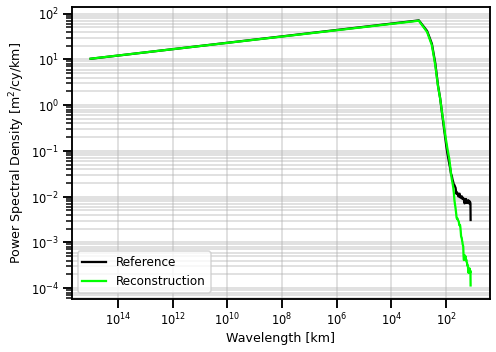

In [156]:
logger.info("Plotting PSD Score...")
fig, ax = plot_psd_spectrum(
    psd_study=psd_metrics.psd_study,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
)

wandb_run.log(
    {
        "psd_spectrum_grid": wandb.Image(fig),
    }
)

#### Viz - PSD Score

2022-07-06 11:54:18.942 | INFO     | __main__:<cell line: 1>:1 - Plotting PSD Score...


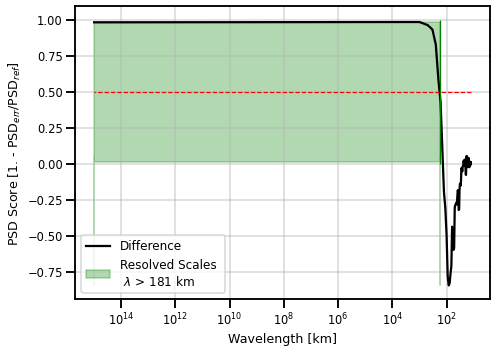

2022-07-06 11:54:19.174 | INFO     | __main__:<cell line: 15>:15 - Finished Script...!


In [157]:
logger.info("Plotting PSD Score...")
fig, ax = plot_psd_score(
    psd_diff=psd_metrics.psd_diff,
    psd_ref=psd_metrics.psd_ref,
    wavenumber=psd_metrics.wavenumber,
    resolved_scale=psd_metrics.resolved_scale,
)

wandb_run.log(
    {
        "psd_score_grid": wandb.Image(fig),
    }
)

logger.info("Finished Script...!")

In [158]:
wandb_run.finish()

nrmse_mean_alongtrack_custom,▁
nrmse_mean_alongtrack_iqr,▁
nrmse_mean_alongtrack_mean,▁
nrmse_mean_alongtrack_minmax,▁
nrmse_mean_alongtrack_std,▁
nrmse_mean_grid,▁
nrmse_std_alongtrack_custom,▁
nrmse_std_alongtrack_iqr,▁
nrmse_std_alongtrack_mean,▁
nrmse_std_alongtrack_minmax,▁
nrmse_std_alongtrack_std,▁


## Visualization

#### SSH Field

In [60]:
# import hvplot.xarray

In [61]:
# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="viridis")

In [45]:
save_path = wandb.run.dir

In [46]:
create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred.mp4
GIF created at movie_pred.gif


#### Gradient (Norm)

In [47]:
from inr4ssh._src.operators.finite_diff import calculate_gradient, calculate_laplacian

ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [48]:
create_movie(
    ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path
)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred_grad.mp4
GIF created at movie_pred_grad.gif


In [49]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="Spectral_r")

#### Laplacian (Norm)

In [50]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [51]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True,
#     width=500, height=400, cmap="RdBu_r")

In [52]:
create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)

/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/Users/eman/miniconda3/envs/torch_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

Movie created at movie_pred_lap.mp4
GIF created at movie_pred_lap.gif


In [53]:
# def custom_plotfunc(ds, fig, tt, *args, **kwargs):

#     # find indices
#     indx = np.where(
#         (np.abs(ds_test_obs_summer.time.values - ds.time.values[tt]) <= dt)
#     )[0]

#     # subset data
#     lat = ds_test_obs_summer.latitude.values[indx]
#     lon = ds_test_obs_summer.longitude.values[indx]
#     data = ds_test_obs_summer.sla_unfiltered.values[indx]

#     vmin = ds_test_obs_summer.sla_unfiltered.min()
#     vmax = ds_test_obs_summer.sla_unfiltered.max()

#     # do scatter plot
#     ax = fig.add_subplot(111, aspect="equal")

#     pts = ax.scatter(
#         lon,
#         lat,
#         c=data,
#         cmap="RdBu_r",
#         vmin=ds_test_obs_summer.sla_unfiltered.min(),
#         vmax=ds_test_obs_summer.sla_unfiltered.max(),
#     )
#     ax.set_title("")
#     ax.set_facecolor("0.5")
#     ax.set_aspect(0.75)
#     ax.set(
#         xlim=[ds.longitude.values.min() - 0.5, ds.longitude.values.max() + 0.5],
#         ylim=[
#             ds.latitude.values.min() - 0.5,
#             ds.latitude.values.max() + 0.5,
#         ],
#     )
#     plt.colorbar(pts)
#     # plt.tight_layout()

#     return None, None

In [54]:
# mov_custom = Movie(ds_summer.sla, custom_plotfunc)

In [55]:
# mov_custom.preview(9)

In [56]:
# mov_custom.save(
#     "plots/movie_ssh_gulf_jja_test.gif",
#     remove_movie=True,
#     progress=True,
#     framerate=5,
#     gif_framerate=5,
#     overwrite_existing=True,
# )

In [57]:
# def make_customplotfunc(ds_obs):
#     def f(ds, fig, tt, *args, **kwargs):

#         # find indices
#         indx = np.where((np.abs(ds_obs.time.values - ds.time.values[tt]) <= dt))[0]

#         # subset data
#         lat = ds_obs.latitude.values[indx]
#         lon = ds_obs.longitude.values[indx]
#         data = ds_obs.sla_unfiltered.values[indx]

#         vmin = ds_obs.sla_unfiltered.min()
#         vmax = ds_obs.sla_unfiltered.max()

#         # do scatter plot
#         ax = fig.add_subplot(111, aspect="equal")

#         pts = ax.scatter(
#             lon,
#             lat,
#             c=data,
#             cmap="RdBu_r",
#             vmin=ds_obs.sla_unfiltered.min(),
#             vmax=ds_obs.sla_unfiltered.max(),
#         )
#         ax.set_title(f"{ds.time.values[tt]:.10}")
#         ax.set_facecolor("0.5")
#         ax.set_aspect(0.75)
#         ax.set(
#             xlim=[ds.longitude.values.min() - 0.5, ds.longitude.values.max() + 0.5],
#             ylim=[
#                 ds.latitude.values.min() - 0.5,
#                 ds.latitude.values.max() + 0.5,
#             ],
#             xlabel="Longitudes [degrees_east]",
#             ylabel="Latitudes [degrees_north]",
#         )
#         plt.colorbar(pts)
#         plt.tight_layout()

#         return None, None

#     return f

In [58]:
# f_cust = make_customplotfunc(ds_test_obs_winter)

# mov_custom = Movie(ds_winter.sla, f_cust)

In [59]:
# mov_custom.save(
#     "plots/movie_ssh_gulf_djf_test.gif",
#     remove_movie=True,
#     progress=True,
#     framerate=5,
#     gif_framerate=5,
#     overwrite_existing=True,
# )